In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import chi2_contingency
from sklearn.feature_selection import SelectKBest, chi2

In [2]:
# Загружаем данные
data = pd.read_csv('Coffe_sales.csv')

In [3]:
# 1. Выбираем целевую переменную
# Выберем coffee_name как целевую переменную
y = data['coffee_name']
X = data.drop('coffee_name', axis=1)

In [4]:
# 2. Разведочный анализ
# Анализ зависимостей между категориальными переменными
categorical_cols = ['cash_type', 'Time_of_Day', 'Weekday', 'Month_name']

# Пример проверки зависимости между двумя категориальными переменными
contingency = pd.crosstab(data['Time_of_Day'], data['Weekday'])
chi2_stat, p_value, dof, expected = chi2_contingency(contingency)
print(f"Chi2 статистика: {chi2_stat}, p-value: {p_value}")


Chi2 статистика: 43.983942341610536, p-value: 1.536805898181957e-05


In [5]:
# 3. Выбор лучших признаков
# Используем SelectKBest для выбора лучших признаков
selector = SelectKBest(score_func=chi2, k=5)
X_new = selector.fit_transform(X, y)

ValueError: could not convert string to float: 'card'

In [6]:
# 4. Нормализация данных
# Определяем числовые и категориальные признаки
numeric_features = ['hour_of_day', 'money', 'Weekdaysort', 'Monthsort']
categorical_features = ['cash_type', 'Time_of_Day', 'Weekday', 'Month_name']

# Создаем препроцессинг пайплайн
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)])

In [7]:
# 5. Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# 6. Создание и обучение модели
model = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', LogisticRegression(max_iter=1000))])
model.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Матрица ошибок:
[[108   1   0   0  19   0   0   0]
 [  0 161   0   0   0   0   0   2]
 [  0   0  19   2   0   0   4  65]
 [  0   0   7   4   0   0   6  28]
 [ 32   0   0   0  16   0   0   0]
 [  4   0   0   0   0  16   0   0]
 [  0   0  15   1   0   0   7  37]
 [  0   0  23   2   0   0   9 122]]

Отчет классификации:
                     precision    recall  f1-score   support

          Americano       0.75      0.84      0.79       128
Americano with Milk       0.99      0.99      0.99       163
         Cappuccino       0.30      0.21      0.25        90
              Cocoa       0.44      0.09      0.15        45
            Cortado       0.46      0.33      0.39        48
           Espresso       1.00      0.80      0.89        20
      Hot Chocolate       0.27      0.12      0.16        60
              Latte       0.48      0.78      0.60       156

           accuracy                           0.64       710
          macro avg       0.59      0.52      0.53       710
       w

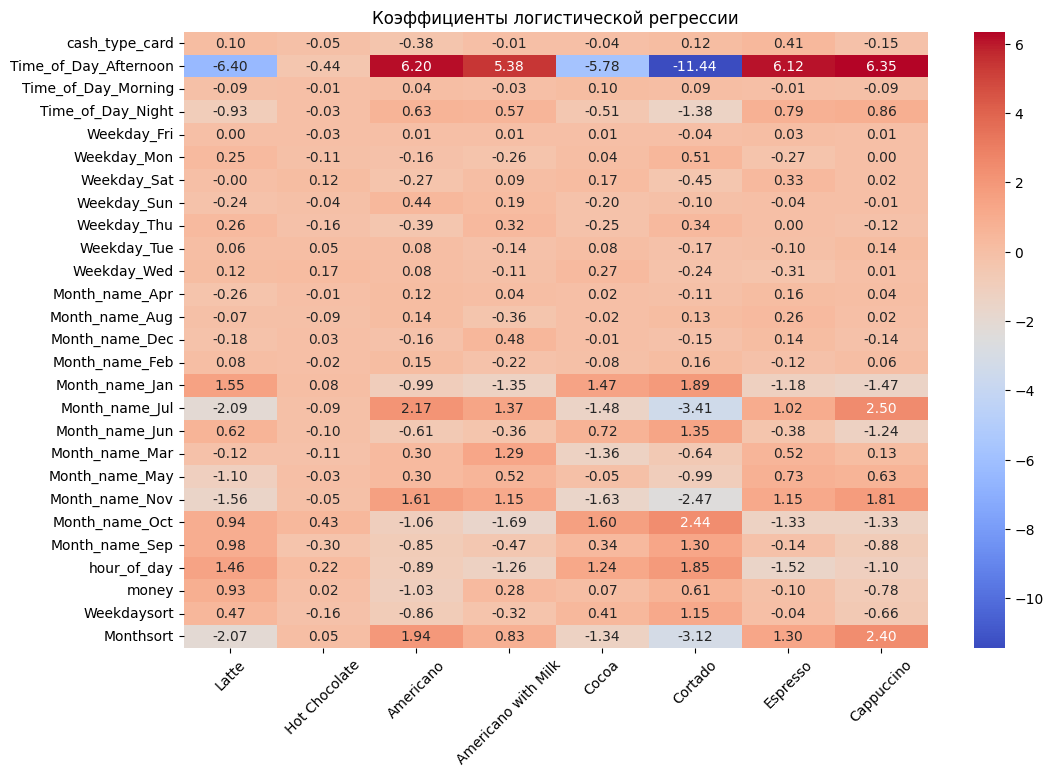

In [11]:
# 7. Оценка модели
y_pred = model.predict(X_test)

# Выводим метрики качества
print("Матрица ошибок:")
print(confusion_matrix(y_test, y_pred))
print("\nОтчет классификации:")
print(classification_report(y_test, y_pred))
print(f"\nТочность модели: {accuracy_score(y_test, y_pred)}")

# Получаем коэффициенты модели
coefficients = model.named_steps['classifier'].coef_

# Получаем имена признаков после OneHotEncoding
# Сначала получаем имена для категориальных признаков
categorical_features_encoded = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Объединяем с числовыми признаками
feature_names = np.concatenate([
    categorical_features_encoded,
    numeric_features
])

# Создаем DataFrame с коэффициентами
coef_df = pd.DataFrame(
    coefficients.T, 
    index=feature_names, 
    columns=data['coffee_name'].unique()
)

print("\nКоэффициенты модели:")
print(coef_df)

# Дополнительная визуализация коэффициентов
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(coef_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Коэффициенты логистической регрессии')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()